<a href="https://colab.research.google.com/github/xtianu/CV_Tirana/blob/main/M3_Image%20Classification/p1_Object_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODULE 3: IMAGE CLASSIFICATION

Christian Mata, PhD

# Pattern Recognition in digital images

This notebook will guide you through three different approaches do recognize patterns in digital images:

1. Object recognition using regional properties: We first segment the objects, extract some attributes (shape, size, etc) and train a classifier that recognizes the different types of objects.

2. Face recognition using PCA features: USe PCA in order to extract meaningful features that allow classifying images to recognize faces.

3. Deep learning: Feature extraction is performed using a convolutional neural network. The classification can be either integrated in a artificial neural network architecture or used in another supervised classifier.

Connecting to Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PART 1: Object recognition using regional properties

Let's start with an image with circles and triangles of different sizes:

### 1. Generation of the sample image:

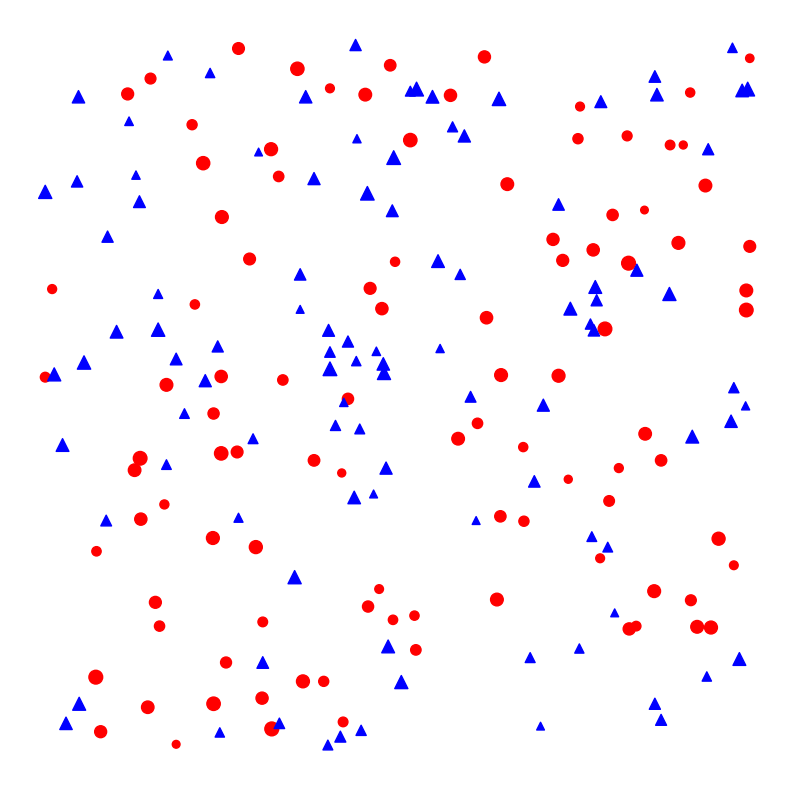

In [ ]:
import numpy as np
np.random.seed(13)

import matplotlib.pyplot as plt
Isize = 1024
N = 100

X = np.random.randint(Isize, size=(2,2*N)) # random placement of objects

fig = plt.figure(figsize=(10,10))
symsizes1 = np.random.randint(30,100,size=(1,N))
symsizes2 = np.random.randint(30,100,size=(1,N))
plt.scatter(X[0,0:N], X[1,0:N], s=symsizes1, c='r',edgecolor="red",marker = 'o')
plt.scatter(X[0,N:2*N], X[1,N:2*N], s=symsizes2, c='b',edgecolor="blue",marker = '^')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/UT/TiranaCV2025/Patterns_result.png',dpi=600, facecolor='w',bbox_inches='tight')
plt.show()

### Reading the image:

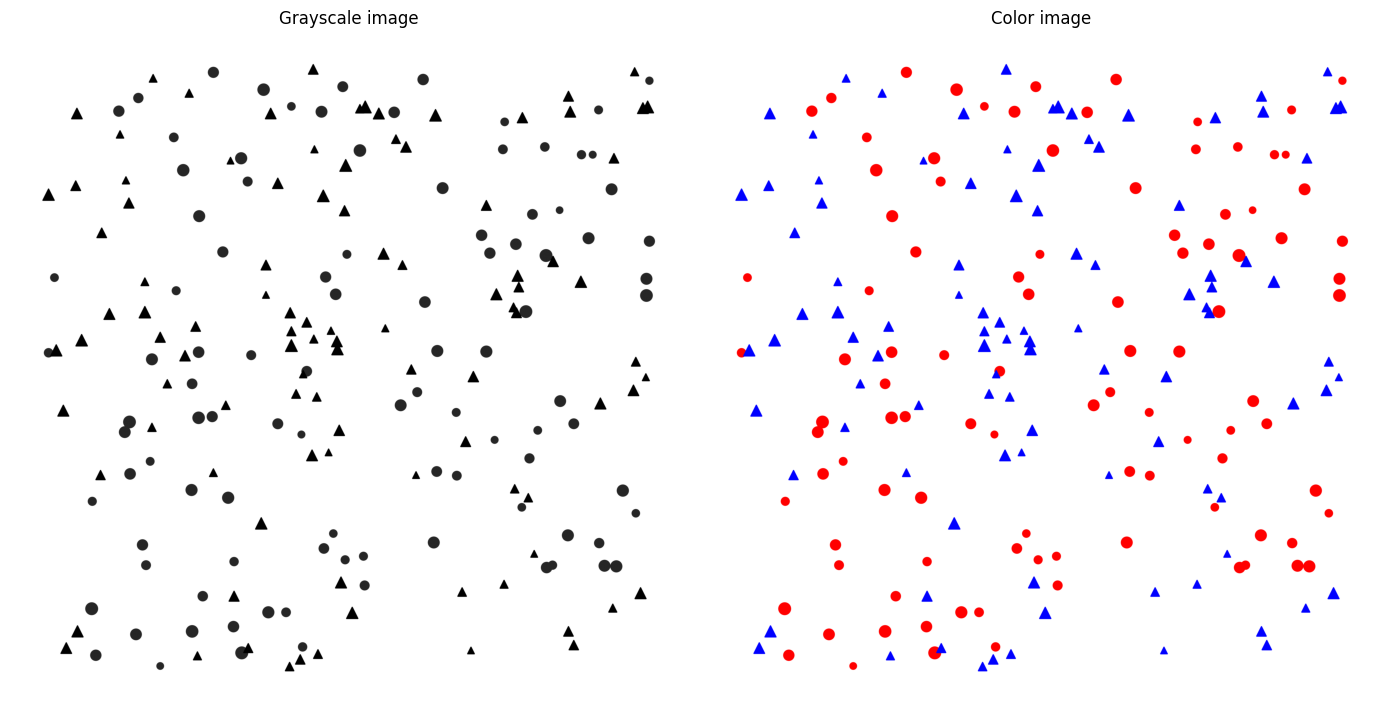

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label

I = io.imread('/content/drive/MyDrive/UT/TiranaCV2025/Patterns_result.png',as_gray=True) # read image as grayscale (no color information)
IC = io.imread('/content/drive/MyDrive/UT/TiranaCV2025/Patterns_result.png') # read image as color (to define object class labels: triangle, circle)

fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Grayscale image')
ax[1].imshow(IC,cmap=plt.cm.jet)
ax[1].set_title('Color image') # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2. Segmentation and regional features:

We now segment and extract regional properties:

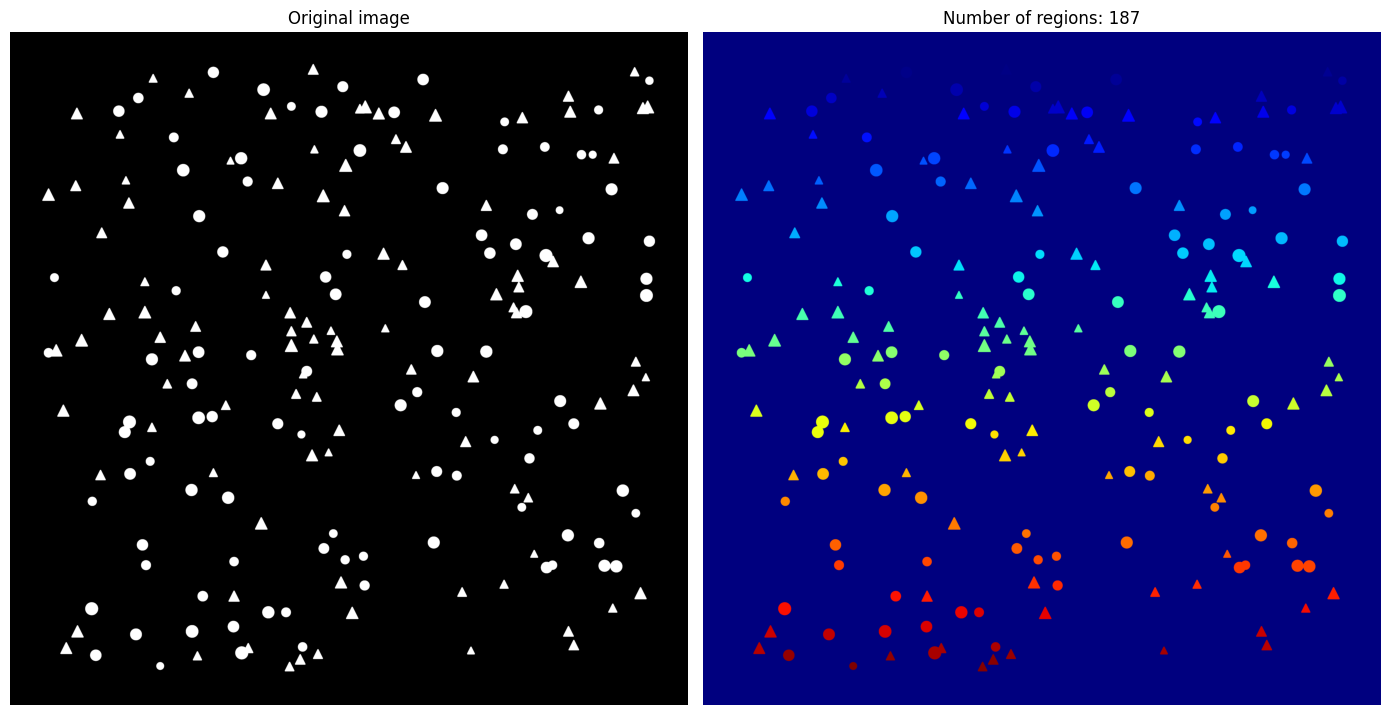

In [ ]:
bw = np.logical_not(I==1)# Set regions white and background black
# label image regions:
label_image, nregions = label(bw,return_num=True)

# Segmentation figure:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(bw,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

# Get regional properties:
from skimage.measure import regionprops
props = regionprops(label_image)

# Get relevant features (eccentricity and area, for instance)
features = np.zeros((nregions,3))
labels = np.zeros(nregions)
# Save class label of each object (1: triangle, 2:circle)
bw1 = np.array(IC[:,:,0]==0,dtype=np.uint8)
bw2 = np.array(IC[:,:,2]==0,dtype=np.uint8)

for i in range(0, nregions):
    features[i, 0] = props[i].eccentricity
    features[i, 1] = props[i].area
    features[i, 2] = props[i].solidity

    # Get centroid coordinates and ensure they are within bounds
    row = int(props[i].centroid[0])
    col = int(props[i].centroid[1])
    row = min(max(0, row), bw1.shape[0] - 1)  # Clamp row to valid range
    col = min(max(0, col), bw1.shape[1] - 1)  # Clamp col to valid range

    labels[i] = bw1[row, col] + 2 * bw2[row, col]

### 3. Exploratory analysis of features:

A scatterplot of features shows that circles present low eccentricity whereas triangles present eccentricity around 0.5. There are some observations with higher eccentricities due to the overlaping cases between triangles and circles.

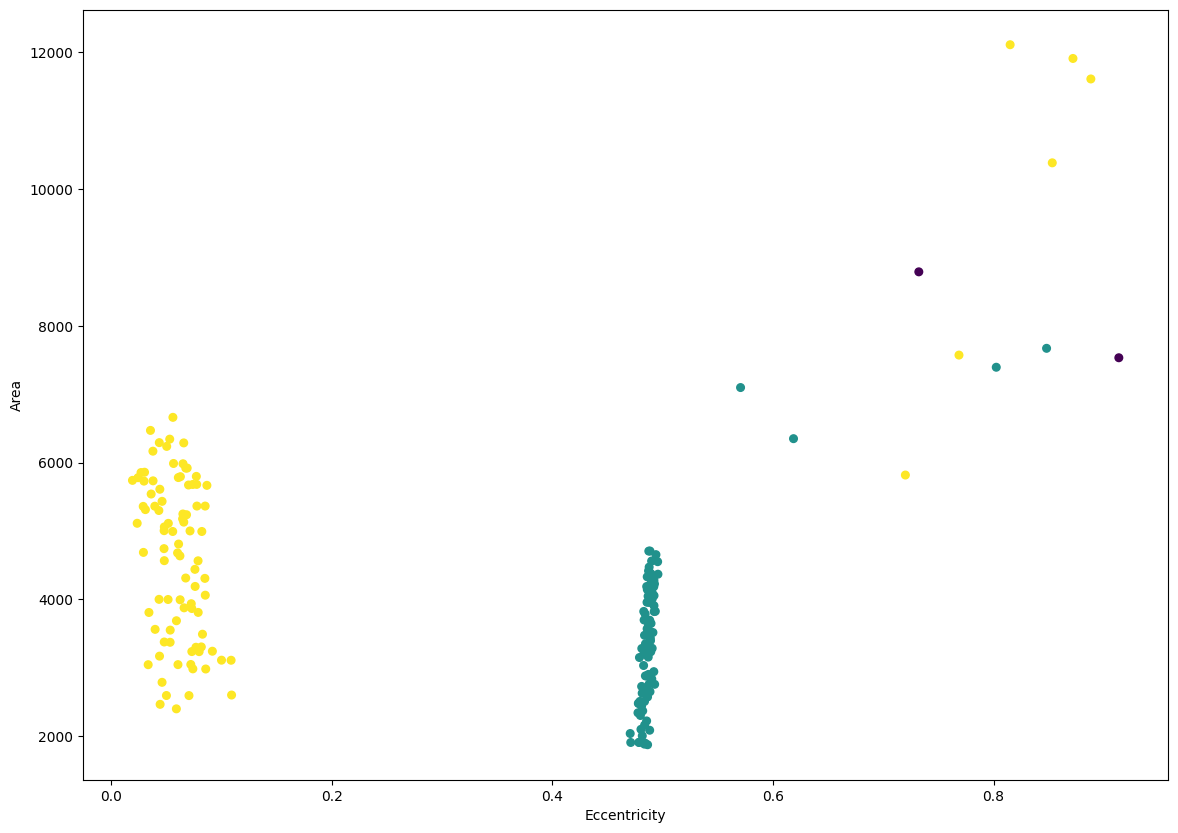

In [ ]:
fig = plt.figure(figsize=(14,10))
plt.scatter(features[:,0], features[:,1], s=30, c=labels,marker = 'o')
plt.xlabel('Eccentricity')
plt.ylabel('Area')
plt.show()

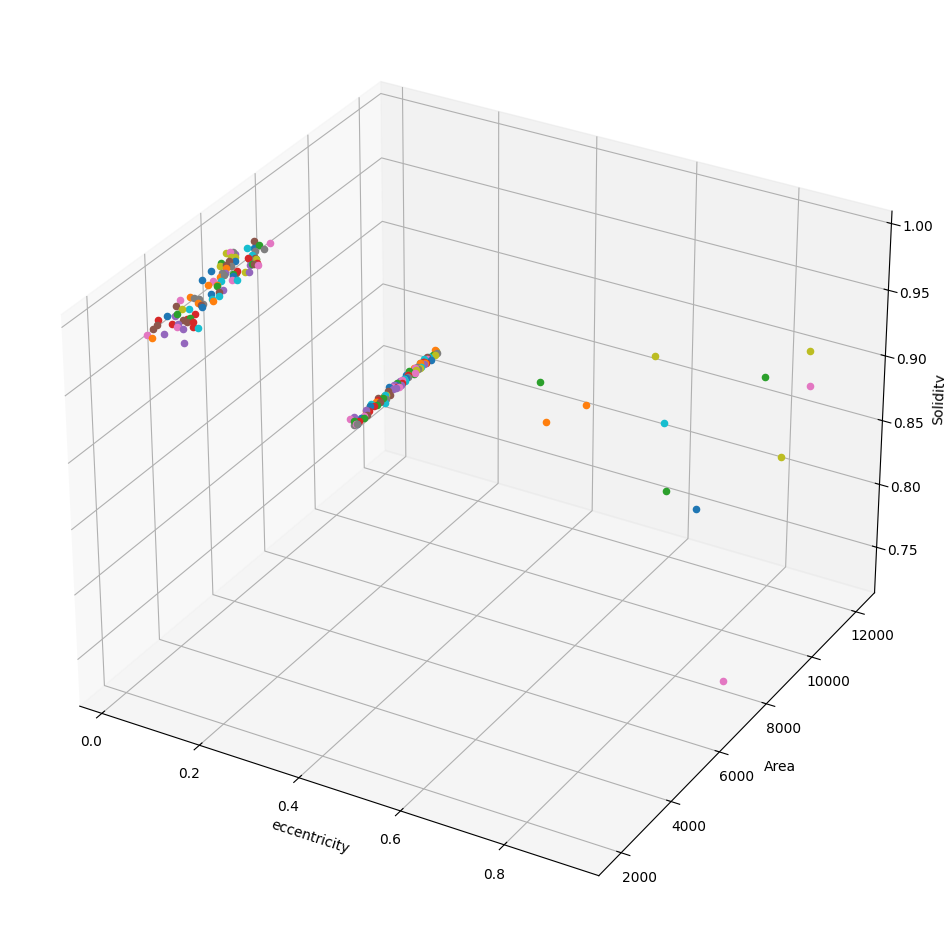

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')


# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for k in range(features.shape[0]):
    xs = features[k,0]
    ys = features[k,1]
    zs = features[k,2]
    ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('eccentricity')
ax.set_ylabel('Area')
ax.set_zlabel('Solidity')

plt.show()

In [ ]:
features.shape

(187, 3)

In [ ]:
np.unique(labels)

array([0., 1., 2.])

### 4. Fit Linear Discriminant Analysis (LDA):

Using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations. Fit a LDA classifier using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

NTRAIN = 50 # Train with NTRAIN objects

clf = LinearDiscriminantAnalysis()
clf.fit(features[0:NTRAIN,:], labels[0:NTRAIN])

LinearDiscriminantAnalysis()

Evaluate performance using Test dataset:

In [ ]:
labels_pred = clf.predict(features[NTRAIN+1:-1])
labels_true = labels[NTRAIN+1:-1]

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_true,labels_pred)
CM

array([[ 0,  2,  0],
       [ 0, 62,  0],
       [ 0,  6, 65]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels_true,labels_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.89      1.00      0.94        62
         2.0       1.00      0.92      0.96        71

    accuracy                           0.94       135
   macro avg       0.63      0.64      0.63       135
weighted avg       0.93      0.94      0.93       135



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
